<a href="https://colab.research.google.com/github/dfrey/MyCode/blob/master/NN_based_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic recommender


In this tutorial, we build a simple matrix factorization model using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/) with TFRS. We can use this model to recommend movies for a given user.

### Import TFRS

First, install and import TFRS:

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q jinja2

ERROR: tensorflow-metadata 1.14.0 has requirement absl-py<2.0.0,>=0.9, but you'll have absl-py 2.1.0 which is incompatible.
ERROR: tensorflow-metadata 1.14.0 has requirement protobuf<4.21,>=3.20.3, but you'll have protobuf 4.25.3 which is incompatible.


In [2]:
from typing import Dict, Text

import os
import pprint
import tempfile

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

2024-03-22 16:56:42.627403: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 16:56:42.981372: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 16:56:42.983861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 16:56:44.079412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_74839/2366222083.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use th

### Read the data

In [3]:
ratings_full = tfds.load('movielens/100k-ratings', split="train")

user_ids = ratings_full.map(lambda x: x["user_id"])
unique_user_ids = np.unique(list(tfds.as_numpy(user_ids)))

movie_titles = ratings_full.map(lambda x: x["movie_title"])
unique_movie_titles = np.unique(list(tfds.as_numpy(movie_titles)))

2024-03-22 16:56:46.934409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 16:56:46.934974: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


> ### TODO
>
> Display the ten first examples to explore the list of available informations
>
> Usefull: `Dataset.take(count)`, `tfds.as_numpy()`, `tfds.as_dataframe()`


In [16]:
type(ratings_full)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [19]:
import pandas as pd

In [21]:
print(unique_user_ids.size)
print(unique_movie_titles.size)
print(ratings_full.cardinality().numpy()/(unique_user_ids.size*unique_movie_titles.size))
# TODO add your code here



df_numpy = tfds.as_numpy(ratings_full.take(10))
# tfds.as_numpy()
df_pandas = pd.DataFrame(df_numpy)
df_pandas.head(10)

943
1664
0.06372868912635615


,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'
5,18.0,"[7, 16]",b'325',b'Crash (1996)',19.0,876346551,False,b'601',1,b'artist',4.0,b'99687'
6,18.0,"[2, 3, 4, 12]",b'95',b'Aladdin (1992)',19.0,882064434,True,b'710',17,b'student',3.0,b'92020'
7,25.0,"[0, 5, 14]",b'92',b'True Romance (1993)',34.0,875135363,True,b'833',21,b'writer',2.0,b'90019'
8,25.0,[4],b'425',b'Bob Roberts (1992)',27.0,880844102,True,b'916',18,b'engineer',5.0,b'N2L5N'
9,25.0,"[0, 1, 15, 18]",b'271',b'Starship Troopers (1997)',32.0,884801053,True,b'940',2,b'administrator',2.0,b'02215'


Restrict the dataset to used features.

In [22]:
# Ratings data.
ratings = ratings_full.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "timestamp": x["timestamp"],
})

Split the data into a training set and a testing set.

In [23]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

### Define a model

We can define a prediction model by inheriting from `tf.keras.Model` and implementing the `call` method.

> ### TODO
>
> Draw the model (you can draw it on a piece of paper and scan it, or take a picture of it, and include your picture in the zip file you submit. You should name your file either `[lastname1]-[lastname2]-modeldrawing.jpg/pdf/...` or `[firstname]-[lastname]-modeldrawing.jpg/pdf/...` depending on whether you worked in pairs or alone. 

In [24]:
class DotRankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.layers.Dot(axes=(1))

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = self.user_embeddings(features["user_id"])
    movie_embedding = self.movie_embeddings(features["movie_title"])

    return self.ratings((user_embedding, movie_embedding))

In [25]:
DotRankingModel()({"user_id": ["42","42"], "movie_title":["One Flew Over the Cuckoo's Nest (1975)", "Strictly Ballroom (1992)"]})

/home/ensai/Documents/Cours_ENSAI_3A/Rec_systems/TP/TP2/repo/env/lib/python3.8/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.00018371],
       [-0.00110138]], dtype=float32)>

We can define a TFRS model by inheriting from `tfrs.Model` and implementing the `compute_loss` method.

> ### TODO
>
> Explain the role played by this model

This model encapsulates a rating prediction model and adds to it a ranking task which is is primarily done using the `compute_loss` method. This method compares the computed predictions of our first model against the actual ratings to calculate the loss. This loss, along with the metrics defined in the task (RMSE), is used during training to optimize the model. 

In [26]:
class MovieLensModel(tfrs.models.Model):

  def __init__(self, rating_model: tf.keras.Model):
    super().__init__()
    self.ranking_model = rating_model
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(features)

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")

    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

## Fit and test the model

In [27]:
# Create a retrieval model.
model = MovieLensModel(DotRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
dot_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=10,
    verbose=1)

test_accuracy = dot_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

Epoch 1/10
40/40 [==============================] - 4s 45ms/step - root_mean_squared_error: 3.7045 - loss: 13.6915 - regularization_loss: 0.0000e+00 - total_loss: 13.6915 - val_root_mean_squared_error: 3.7071 - val_loss: 13.7426 - val_regularization_loss: 0.0000e+00 - val_total_loss: 13.7426
Epoch 2/10
40/40 [==============================] - 2s 10ms/step - root_mean_squared_error: 3.7044 - loss: 13.6643 - regularization_loss: 0.0000e+00 - total_loss: 13.6643 - val_root_mean_squared_error: 3.7071 - val_loss: 13.7427 - val_regularization_loss: 0.0000e+00 - val_total_loss: 13.7427
Epoch 3/10
40/40 [==============================] - 2s 9ms/step - root_mean_squared_error: 3.7043 - loss: 13.7314 - regularization_loss: 0.0000e+00 - total_loss: 13.7314 - val_root_mean_squared_error: 3.7071 - val_loss: 13.7427 - val_regularization_loss: 0.0000e+00 - val_total_loss: 13.7427
Epoch 4/10
40/40 [==============================] - 2s 10ms/step - root_mean_squared_error: 3.7043 - loss: 13.6551 - regul

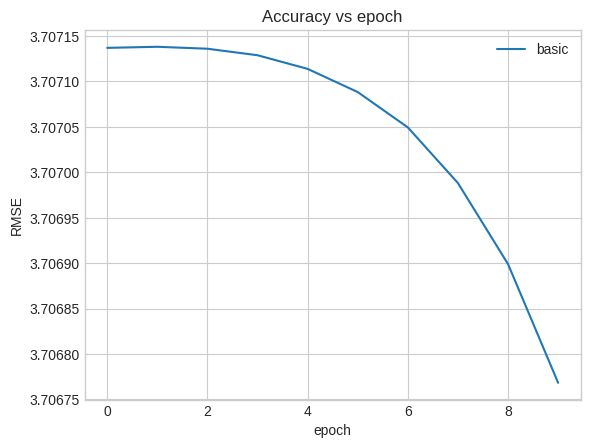

In [28]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

> ### TODO
>
> Comment the curve

The curve shows that the RMSE (the accuracy metric used here) decreases with the numbers of epoch which mean the model is getting better. We can also notice that this decrease rate gets higher with the number of epochs.

> ### TODO
> Can you make the model more accurate? How?

Yes we can make this model more accurate simply by increasing the number of epochs for which it is trained for. 

# More complex link between user's and item's representations

Let replace the dot product between user's and item's representations by a fully connected layer of size 64, followed by a fully connected layer with a unique output.

> ### TODO
>
> - Define the layer and adapt the `call` method
> - Choose carefully the activation functions of the layers
>
> Useful: `tf.keras.Sequential`, `tf.keras.Dense`, `tf.concat`
> 
> You can alo checkout the Tensorflow/Keras tutorial here https://www.tensorflow.org/guide/keras/sequential_model

In [29]:
class OneLayerRankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])


  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = self.user_embeddings(features["user_id"])
    movie_embedding = self.movie_embeddings(features["movie_title"])

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [30]:
OneLayerRankingModel()({"user_id": ["42"], "movie_title":["One Flew Over the Cuckoo's Nest (1975)"]})

/home/ensai/Documents/Cours_ENSAI_3A/Rec_systems/TP/TP2/repo/env/lib/python3.8/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.02805278]], dtype=float32)>

In [31]:
# Create a retrieval model.
model = MovieLensModel(OneLayerRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
one_layer_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=10,
    verbose=1)

test_accuracy = one_layer_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

Epoch 1/10
40/40 [==============================] - 2s 12ms/step - root_mean_squared_error: 1.3909 - loss: 1.9003 - regularization_loss: 0.0000e+00 - total_loss: 1.9003 - val_root_mean_squared_error: 1.0699 - val_loss: 1.1243 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1243
Epoch 2/10
40/40 [==============================] - 2s 9ms/step - root_mean_squared_error: 1.0367 - loss: 1.0713 - regularization_loss: 0.0000e+00 - total_loss: 1.0713 - val_root_mean_squared_error: 1.0089 - val_loss: 1.0066 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0066
Epoch 3/10
40/40 [==============================] - 2s 9ms/step - root_mean_squared_error: 0.9840 - loss: 0.9718 - regularization_loss: 0.0000e+00 - total_loss: 0.9718 - val_root_mean_squared_error: 0.9776 - val_loss: 0.9486 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9486
Epoch 4/10
40/40 [==============================] - 2s 12ms/step - root_mean_squared_error: 0.9582 - loss: 0.9098 - regularization_loss

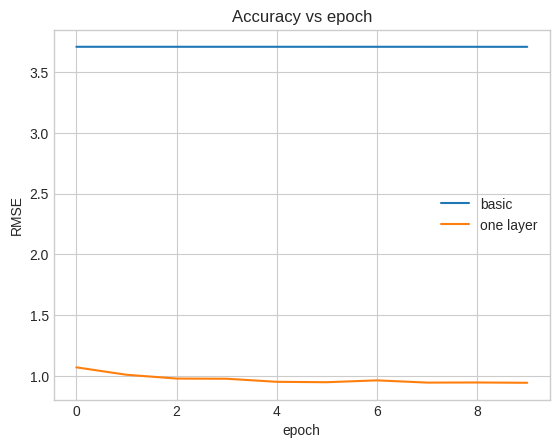

In [32]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

# Taking advantage of context features

Let use timestamps of the ratings and movie titles to enrich the input of the model.

Some preliminary:

In [33]:
timestamps = np.concatenate(list(ratings_full.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

New user model.

> ### TODO
>
> Draw and explain the role played by the components of the model

The overall architecture of the model can be broken down in three part: The first one for precessing the user informations, the second one for processing the movies data and the last one to actually make the prediction. 

- User data processing: 
    * The user ID is processed through a `StringLookup` layer to convert the strings to integer indices and then an `Embedding` layer to produce user embeddings. 
    * The timestamps are processed on one hand through a `Discretization` layer followed by an Embedding layer to capture temporal patterns in user behavior. 
    * On the other hand, the timestamps are processed through a Normalization layer to get standardized. 
    * These three components obtained are concatenated to form the final user embedding.

- Movie data processing:
    * The movie titles are processed through a `StringLookup` and `Embedding` layer to generate movie embeddings.
    * The same movie titles are processed through a  `Text Vectorization` layer followed by an `Embedding` layer and a GlobalAveragePooling1D layer to create another tyoe of embeddings based on the meaning of the movie titles. 
    * The two generated embeddings are the concatenated to form the final movie embedding.

- Prediction:
    * The final user embeddings and  the final movie embeddings are concatenated and passed through a stack of two fully connected (`Dense`) layers to give the predicted movie rating.

In [34]:
class EnrichedRankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Building blocks to compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    self.timestamp_embeddings = tf.keras.Sequential([
        tf.keras.layers.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, embedding_dimension),
    ])

    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )
    self.normalized_timestamp.adapt(timestamps)

    # Building blocks to compute embeddings for movies.
    max_tokens = 10_000

    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
      max_tokens=max_tokens)

    self.title_text_embeddings = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(unique_movie_titles)



    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
    ])

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = tf.concat([
        self.user_embeddings(features["user_id"]),
        self.timestamp_embeddings(features["timestamp"]),
        tf.reshape(self.normalized_timestamp(features["timestamp"]), (-1, 1)),
    ], axis=1)

    movie_embedding = tf.concat([
        self.movie_embeddings(features["movie_title"]),
        self.title_text_embeddings(features["movie_title"]),
    ], axis=1)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [35]:
EnrichedRankingModel()({"user_id": ["42"], "movie_title":["One Flew Over the Cuckoo's Nest (1975)"], "timestamp":[879024327]})

/home/ensai/Documents/Cours_ENSAI_3A/Rec_systems/TP/TP2/repo/env/lib/python3.8/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.07517882]], dtype=float32)>

In [36]:
# Create a retrieval model.
model = MovieLensModel(EnrichedRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
enriched_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=10,
    verbose=1)

test_accuracy = enriched_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

Epoch 1/10
40/40 [==============================] - 4s 26ms/step - root_mean_squared_error: 1.3678 - loss: 1.8353 - regularization_loss: 0.0000e+00 - total_loss: 1.8353 - val_root_mean_squared_error: 1.0774 - val_loss: 1.1437 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1437
Epoch 2/10
40/40 [==============================] - 2s 23ms/step - root_mean_squared_error: 1.0433 - loss: 1.0812 - regularization_loss: 0.0000e+00 - total_loss: 1.0812 - val_root_mean_squared_error: 1.0170 - val_loss: 1.0238 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0238
Epoch 3/10
40/40 [==============================] - 2s 21ms/step - root_mean_squared_error: 0.9875 - loss: 0.9739 - regularization_loss: 0.0000e+00 - total_loss: 0.9739 - val_root_mean_squared_error: 1.0015 - val_loss: 0.9938 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9938
Epoch 4/10
40/40 [==============================] - 2s 20ms/step - root_mean_squared_error: 0.9596 - loss: 0.9128 - regularization_lo

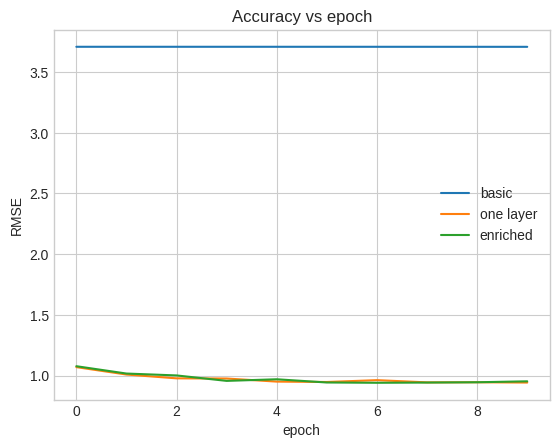

In [37]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.plot(enriched_model_history.history["val_root_mean_squared_error"], label="enriched")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()

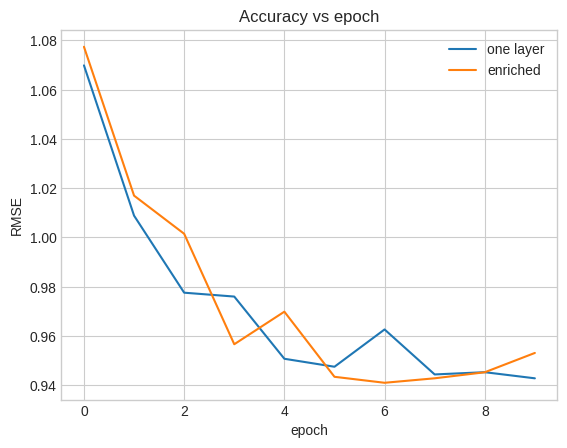

In [38]:
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.plot(enriched_model_history.history["val_root_mean_squared_error"], label="enriched")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()

We can notice that the later model is (as the second one), far better than the first one. But it is not absolutely better than the second model. The last two models have alike performances throught the first ten epochs.

# More comple models



> ### TODO
>
> Build and test more complex models:
> - with more layers to link user's and item's representation
> - integrating more contextual information: user's age, movie's genre, ...



The model below is the last model architecture to which is added two more dense layers at the location of the stack which link user's and movie's final embeddings to make the rating prediction. 

In [42]:
class MoreComplexRankingModel1(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Building blocks to compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    self.timestamp_embeddings = tf.keras.Sequential([
        tf.keras.layers.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, embedding_dimension),
    ])

    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )
    self.normalized_timestamp.adapt(timestamps)

    # Building blocks to compute embeddings for movies.
    max_tokens = 10_000

    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
      max_tokens=max_tokens)

    self.title_text_embeddings = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(unique_movie_titles)



    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(32, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
    ])

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = tf.concat([
        self.user_embeddings(features["user_id"]),
        self.timestamp_embeddings(features["timestamp"]),
        tf.reshape(self.normalized_timestamp(features["timestamp"]), (-1, 1)),
    ], axis=1)

    movie_embedding = tf.concat([
        self.movie_embeddings(features["movie_title"]),
        self.title_text_embeddings(features["movie_title"]),
    ], axis=1)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [43]:
# Create a retrieval model.
complex_model1 = MovieLensModel(MoreComplexRankingModel1())
complex_model1.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
complex_model1_history = complex_model1.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=10,
    verbose=1)

test_accuracy = complex_model1_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

/home/ensai/Documents/Cours_ENSAI_3A/Rec_systems/TP/TP2/repo/env/lib/python3.8/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Epoch 1/10
40/40 [==============================] - 3s 26ms/step - root_mean_squared_error: 1.8093 - loss: 3.1749 - regularization_loss: 0.0000e+00 - total_loss: 3.1749 - val_root_mean_squared_error: 1.1254 - val_loss: 1.2407 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2407
Epoch 2/10
40/40 [==============================] - 2s 25ms/step - root_mean_squared_error: 1.0638 - loss: 1.1486 - regularization_loss: 0.0000e+00 - total_loss: 1.1486 - val_root_mean_squared_error: 1.0592 - val_loss: 1.1146 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1146
Epoch 3/10
40/40 [==============================] - 2s 20ms/step - root_mean_squared_error: 0.9931 - loss: 0.9857 - regularization_loss: 0.0000e+00 - total_loss: 0.9857 - val_root_mean_squared_error: 0.9770 - val_loss: 0.9488 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9488
Epoch 4/10
40/40 [==============================] - 2s 19ms/step - root_mean_squared_error: 0.9557 - loss: 0.9095 - regularization_lo

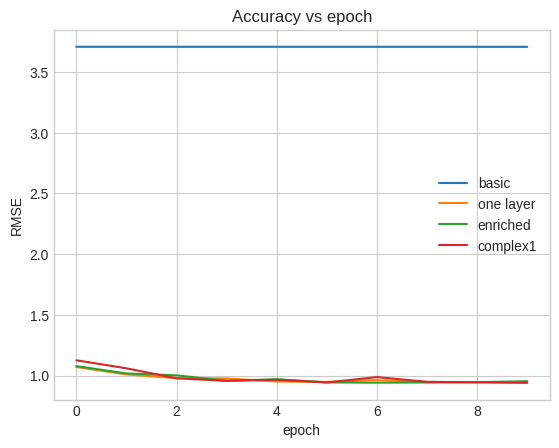

In [44]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.plot(enriched_model_history.history["val_root_mean_squared_error"], label="enriched")
plt.plot(complex_model1_history.history["val_root_mean_squared_error"], label="complex1")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()

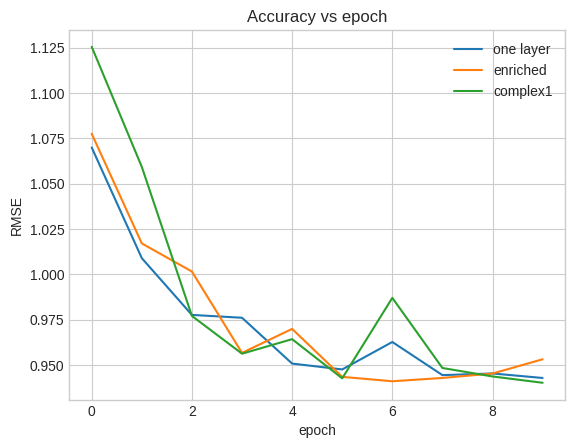

In [45]:
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.plot(enriched_model_history.history["val_root_mean_squared_error"], label="enriched")
plt.plot(complex_model1_history.history["val_root_mean_squared_error"], label="complex1")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()

The model was more complex but doesn't perform better than the two latter. 
These three models have almost the same performance on the test set (RMSE of 0.94-0.95)

Let's now load some more information in our data. 

In [46]:
# Ratings data.
ratings_new = ratings_full.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "timestamp": x["timestamp"],
    "age": x["raw_user_age"],
    "occupation": x["user_occupation_label"]
})

In [47]:
tf.random.set_seed(42)
shuffled_new = ratings_new.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train_new = shuffled_new.take(80_000)
test_new = shuffled_new.skip(80_000).take(20_000)

cached_train_new = train.shuffle(100_000).batch(2048)
cached_test_new = test_new.batch(4096).cache()

Then in the model, we are going to add the user's age and the encoded occupation of the user to the final user's embeddings. 

In [66]:
class MoreComplexRankingModel2(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Building blocks to compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    self.timestamp_embeddings = tf.keras.Sequential([
        tf.keras.layers.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, embedding_dimension),
    ])

    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )
    self.normalized_timestamp.adapt(timestamps)

    # Building blocks to compute embeddings for movies.
    max_tokens = 10_000

    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
      max_tokens=max_tokens)

    self.title_text_embeddings = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(unique_movie_titles)



    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
    ])

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = tf.concat([
        self.user_embeddings(features["user_id"]),
        self.timestamp_embeddings(features["timestamp"]),
        tf.reshape(self.normalized_timestamp(features["timestamp"]), (-1, 1)),
        # add user age and occupation after converting them to float32
        tf.reshape(tf.cast(features["age"], tf.float32), (-1, 1)),
        tf.reshape(tf.cast(features["occupation"], tf.float32), (-1, 1)),
    ], axis=1)

    movie_embedding = tf.concat([
        self.movie_embeddings(features["movie_title"]),
        self.title_text_embeddings(features["movie_title"]),
    ], axis=1)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [67]:
MoreComplexRankingModel2()({"user_id": ["42"], "movie_title":["One Flew Over the Cuckoo's Nest (1975)"], "timestamp":[879024327], "occupation":[10], "age":[24]})

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.403909]], dtype=float32)>

In [68]:
# Create a retrieval model.
complex_model2 = MovieLensModel(MoreComplexRankingModel2())
complex_model2.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
complex_model2_history = model.fit(
    cached_train_new,
    validation_data=cached_test_new,
    validation_freq=1,
    epochs=10,
    verbose=1)

test_accuracy = complex_model2_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

Epoch 1/10
40/40 [==============================] - 4s 58ms/step - root_mean_squared_error: 0.9121 - loss: 0.8276 - regularization_loss: 0.0000e+00 - total_loss: 0.8276 - val_root_mean_squared_error: 0.9366 - val_loss: 0.8759 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8759
Epoch 2/10
40/40 [==============================] - 2s 20ms/step - root_mean_squared_error: 0.9116 - loss: 0.8302 - regularization_loss: 0.0000e+00 - total_loss: 0.8302 - val_root_mean_squared_error: 0.9388 - val_loss: 0.8813 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8813
Epoch 3/10
40/40 [==============================] - 2s 18ms/step - root_mean_squared_error: 0.9113 - loss: 0.8361 - regularization_loss: 0.0000e+00 - total_loss: 0.8361 - val_root_mean_squared_error: 0.9512 - val_loss: 0.9074 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9074
Epoch 4/10
40/40 [==============================] - 2s 19ms/step - root_mean_squared_error: 0.9115 - loss: 0.8209 - regularization_lo

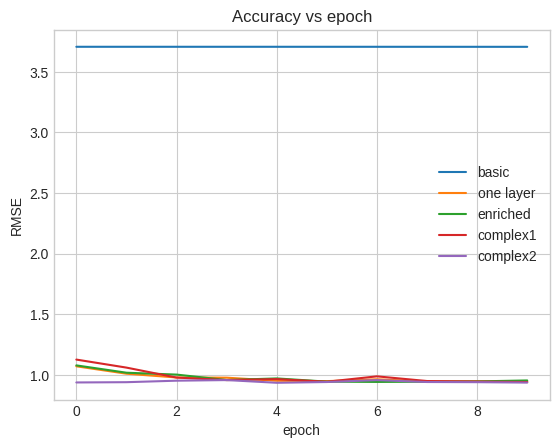

In [69]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.plot(enriched_model_history.history["val_root_mean_squared_error"], label="enriched")
plt.plot(complex_model1_history.history["val_root_mean_squared_error"], label="complex1")
plt.plot(complex_model2_history.history["val_root_mean_squared_error"], label="complex2")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()

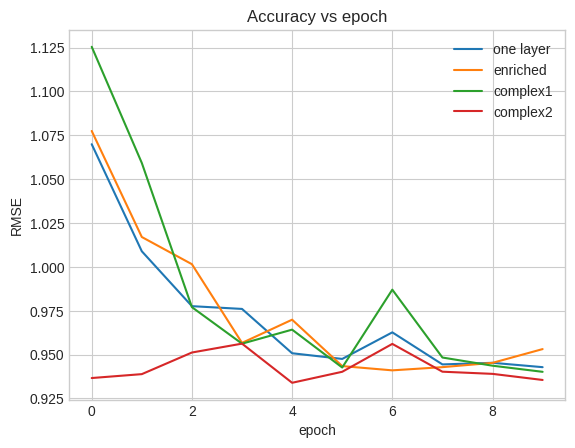

In [70]:
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.plot(enriched_model_history.history["val_root_mean_squared_error"], label="enriched")
plt.plot(complex_model1_history.history["val_root_mean_squared_error"], label="complex1")
plt.plot(complex_model2_history.history["val_root_mean_squared_error"], label="complex2")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()

In terms of performance on the test set, the second complex model has the same performance (RMSE of 0.94) than the others (except, of course, the first model). But we can see from the graph that it starts learns very quickly right from the beginning. 

# Copyright

Several section of this notebook originate from notebooks under the following copyright:

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.